In [1]:
import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
import pandas as pd
%matplotlib inline

torch.set_default_tensor_type(torch.cuda.FloatTensor)

c:\Users\ACT\anaconda3\envs\nocd\Lib\site-packages\torch\__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [2]:
df1=pd.read_csv('./dataset/ogbn_proteins/raw/edge.csv.gz')
df2=pd.read_csv('./dataset/ogbn_proteins/raw/node_species.csv.gz')

In [3]:
species_dict={}
for species_id in df2['3702'].unique():
    species_dict[species_id]=[]
node_id=1
for species_id in df2['3702']:
    species_dict[species_id].append(node_id)
    node_id+=1

In [4]:
import networkx as nx
species=[4932,511145]
nodes=[]
for species_id in species:
    nodes=nodes+species_dict[species_id]
G = nx.from_pandas_edgelist(df1, "1", "96401")
G=nx.subgraph(G,nodes)

In [5]:
for u,v in G.edges():
    G[u][v]['weight'] = 1

In [6]:
A=nx.to_scipy_sparse_matrix(G, format='csr')
A

In [7]:
node_labels = np.loadtxt('./dataset/ogbn_proteins/raw/node-label.csv.gz', delimiter=',', dtype=int)

In [8]:
X=[]
for i in G.nodes:
    X.append(node_labels[i])
X=np.array(X)
X=csr_matrix(X)

In [9]:
species_data=[]
species_data2 = np.loadtxt('./dataset/ogbn_proteins/raw/node_species.csv.gz', delimiter=',', dtype=str)
for i in G.nodes:
    species_data.append(species_data2[i])
species_data=np.array(species_data)

In [10]:
unique_species = np.unique(species_data)
unique_protein_ids = np.arange(len(species_data))
affiliation_matrix = np.zeros((len(unique_protein_ids), len(unique_species)), dtype=int)
for i, protein_id in enumerate(unique_protein_ids):
    species = species_data[i]
    j = np.where(unique_species == species)[0][0]
    affiliation_matrix[i, j] = 1

In [11]:
Z_gt=affiliation_matrix
orG = G
N, K = Z_gt.shape

In [12]:
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 500        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)

In [13]:
x_norm = normalize(X)  # node features
# x_norm = normalize(A)  # adjacency matrix
# x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()

d:\Muttakin\overlapping-community-detection\nocd\utils.py:35: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:620.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, shape)


In [14]:
sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = nocd.nn.GCN(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout).cuda()
adj_norm = gnn.normalize_adj(A)
decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)

In [15]:
def get_nmi(thresh=0.5):
    """Compute Overlapping NMI of the communities predicted by the GNN."""
    gnn.eval()
    Z = F.relu(gnn(x_norm, adj_norm))
    Z_pred = Z.cpu().detach().numpy() > thresh
    nmi = nocd.metrics.overlapping_nmi(Z_pred, Z_gt)
    return nmi

In [16]:
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
model_saver = nocd.train.ModelSaver(gnn)

for epoch, batch in enumerate(sampler):
    if epoch > max_epochs:
        break
    if epoch % 25 == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            Z = F.relu(gnn(x_norm, adj_norm))
            val_loss = decoder.loss_full(Z, A)
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {get_nmi():.2f}')
            
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
            
    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(x_norm, adj_norm))
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    loss.backward()
    opt.step()

d:\Muttakin\overlapping-community-detection\nocd\nn\gcn.py:18: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:85.)
  return torch.cuda.sparse.FloatTensor(x.indices(), new_values, x.size())


Epoch    0, loss.full = 0.9158, nmi = 0.03
Epoch   25, loss.full = 0.3512, nmi = 0.26
Epoch   50, loss.full = 0.3160, nmi = 0.32
Epoch   75, loss.full = 0.3061, nmi = 0.35
Epoch  100, loss.full = 0.2998, nmi = 0.35
Epoch  125, loss.full = 0.2958, nmi = 0.38
Epoch  150, loss.full = 0.2935, nmi = 0.38
Epoch  175, loss.full = 0.2915, nmi = 0.41
Epoch  200, loss.full = 0.2909, nmi = 0.43
Epoch  225, loss.full = 0.2884, nmi = 0.47
Epoch  250, loss.full = 0.2856, nmi = 0.50
Epoch  275, loss.full = 0.2853, nmi = 0.51
Epoch  300, loss.full = 0.2853, nmi = 0.51
Epoch  325, loss.full = 0.2840, nmi = 0.50
Epoch  350, loss.full = 0.2826, nmi = 0.50
Epoch  375, loss.full = 0.2824, nmi = 0.51
Epoch  400, loss.full = 0.2819, nmi = 0.50
Epoch  425, loss.full = 0.2825, nmi = 0.50
Epoch  450, loss.full = 0.2812, nmi = 0.50
Epoch  475, loss.full = 0.2817, nmi = 0.50
Epoch  500, loss.full = 0.2824, nmi = 0.50


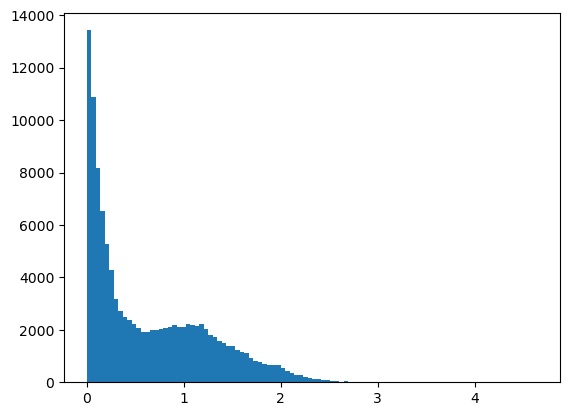

In [17]:
plt.hist(Z[Z > 0].cpu().detach().numpy(), 100);

In [18]:
thresh = 0.5

Z = F.relu(gnn(x_norm, adj_norm))
Z_pred = Z.cpu().detach().numpy() > thresh
model_saver.restore()
print(f'Final nmi = {get_nmi(thresh):.3f}')

Final nmi = 0.505


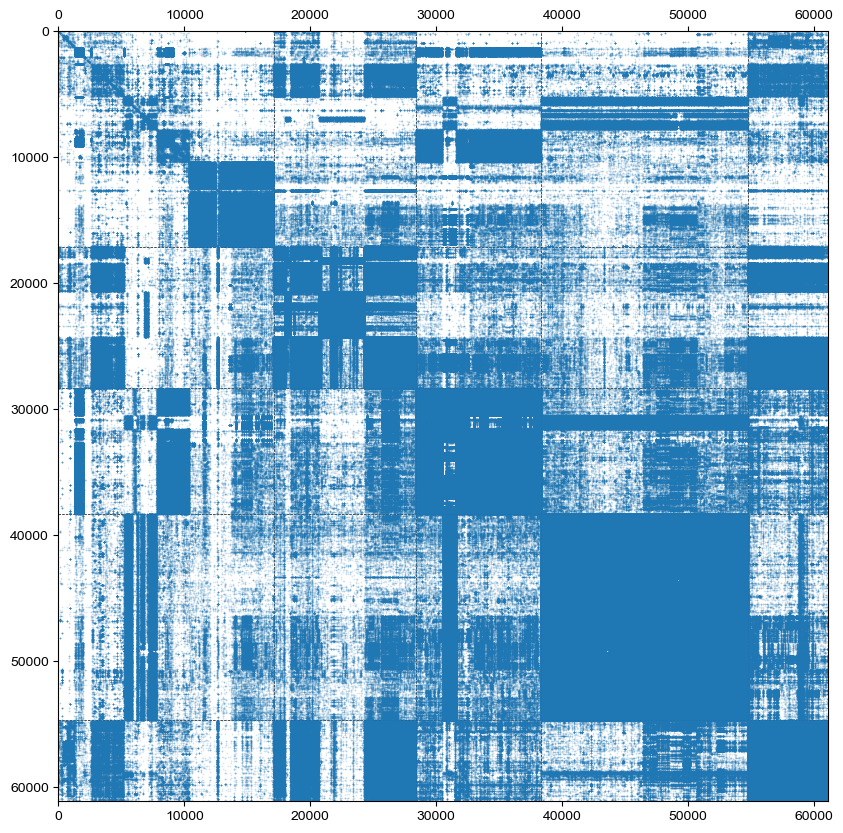

In [19]:
plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
o = np.argsort(z)
nocd.utils.plot_sparse_clustered_adjacency(A, K, z, o, markersize=0.05)

In [20]:
# Sizes of detected communities
print(Z_pred.sum(0))

[ 6672 11282 10629 16873  9432]


In [21]:
metrics = nocd.metrics.evaluate_unsupervised(Z_gt, A)
print(f"Ground truth communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

d:\Muttakin\overlapping-community-detection\nocd\metrics\unsupervised.py:29: RuntimeWarning: overflow encountered in scalar multiply
  possible = (n - 2) * (n - 1) * n / 6


Ground truth communities:
 - coverage    = 0.9382
 - conductance = 0.0644
 - density     = 3.041e-02
 - clust_coef  = 5.443e-02


In [22]:
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Predicted communities:
 - coverage    = 0.9269
 - conductance = 0.1343
 - density     = 4.151e-02
 - clust_coef  = -5.587e-02


In [41]:
def get_comlist(community_matrix):
    transposed_matrix = np.transpose(community_matrix)

    # Initialize an empty list to store tuples (community_id, nodes_list)
    community_nodes_list = []

    # Iterate through rows (communities)
    for community_id, community_row in enumerate(transposed_matrix):
        # Find nodes (columns) where the value is 1
        community_nodes = np.where(community_row == 1)[0].tolist()
        
        # Append a tuple to the list containing community ID and nodes list
        community_nodes_list.append(community_nodes)
    
    return community_nodes_list

In [42]:
from cdlib import NodeClustering
from cdlib import evaluation

coms1=get_comlist(Z_gt)
coms2=get_comlist(Z_pred)

communities1=NodeClustering(coms1,G)
communities2=NodeClustering(coms2,G)

onmi=evaluation.overlapping_normalized_mutual_information_LFK(communities1,communities2)
print(onmi)

MatchingResult(score=0.4964977099618655, std=None)
